In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#%matplotlib notebook

from sklearn.manifold import TSNE
from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score, cohen_kappa_score, f1_score

from sklearn.decomposition import NMF
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from scipy.sparse import hstack
import datetime

from learning_utils import utils
import importlib
importlib.reload(utils)

double_figure = (7.2,7.2/8*5)
plt.rc('font',size=7)
plt.rc('axes',titlesize=7)
plt.rc('axes',labelsize=7)
plt.rc('xtick',labelsize=7)
plt.rc('ytick',labelsize=7)
plt.rc('legend',fontsize=7)
plt.rc('figure',titlesize=7)

In [2]:
df = pd.read_csv('docs.csv').sample(frac=1).reset_index(drop=True)
df['date'] = df['rated'].apply(lambda x: datetime.datetime.strptime(x[:19],"%Y-%m-%d %H:%M:%S"))
df = df[df['date'] > datetime.datetime(2018,6,1,0,0,0)].reset_index(drop=True)
print(df.shape)
y = df['relevant']
df.head()

(1984, 13)


,Unnamed: 0,UT_id,authors,content,first_author,id,rated,relevant,tag,title,wosarticle__de,wosarticle__wc,date
0,1037,WOS:A1992KD80500020,"FOELL, WK",As economic adjustments shock the countries of...,"FOELL, WK",364072,2018-09-20 09:57:35.528936+00:00,1,760,ENERGY MANAGEMENT IN EASTERN-EUROPE AND THE FO...,NaN,['Business; International Relations'],2018-09-20 09:57:35
1,121,WOS:000319544900003,"Dourma, M, Wala, K, Guelly, KA, Bellefontaine,...",The open Isoberlinia spp. woodlands found on s...,"Dourma, M",186176,2018-09-20 11:44:03.436003+00:00,1,760,"TYPOLOGY, STRUCTURAL CHARACTERISTICS AND DYNAM...",open Isoberlinia forest; management; structure...,['Forestry'],2018-09-20 11:44:03
2,1588,WOS:000323221500149,"George, AE, Chapman, DC",As bighead carp Hypophthalmichthys nobilis and...,"George, AE",168624,2018-09-24 09:12:33.050141+00:00,1,760,Aspects of Embryonic and Larval Development in...,NaN,['Multidisciplinary Sciences'],2018-09-24 09:12:33
3,558,WOS:000281107500013,"Phong, LT, van Dam, AA, Udo, HMJ, van Mensvoor...",This study compared ecological sustainability ...,"Phong, LT",700879,2018-09-21 15:42:37.412706+00:00,1,760,An agro-ecological evaluation of aquaculture i...,ECO PATH; Integrated Agriculture-Aquaculture; ...,"['Agriculture, Multidisciplinary; Ecology; Env...",2018-09-21 15:42:37
4,2766,WOS:000362851000034,"Morbale, ST, Jadhav, SD, Deshmukh, MB, Patil, SS","A natural biosurfactant, a biobased green acid...","Morbale, ST",453410,2018-09-21 05:02:30.487093+00:00,1,753,Bronsted acid-type biosurfactant for heterocyc...,NaN,"['Chemistry, Multidisciplinary']",2018-09-21 05:02:30


### The sample is unbalanced, with 22% negatives

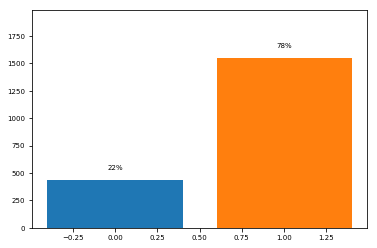

In [3]:
plt.close()
fig, ax = plt.subplots()
i = 0
for name, group in df.groupby('relevant'):
    s = group['id'].size
    plt.bar(i, s)
    plt.text(i, s + df['id'].size*0.05, "{:.0%}".format(s/df['id'].size),ha="center")
    i+=1
    
plt.ylim(0,df['id'].size)
#fig.tight_layout()
    
plt.show()
    

## Generating various feature collections for input

In [4]:
vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=15, max_df=0.6, strip_accents='unicode', 
    use_idf=1,
    smooth_idf=1, sublinear_tf=1,
    stop_words="english",tokenizer=utils.tokenize
)

ab_X = vec.fit_transform(df['content'])
ab_X.shape

(1984, 2088)

In [5]:
vec = TfidfVectorizer(
    ngram_range=(1,3),
    min_df=5, max_df=0.8, strip_accents='unicode', 
    use_idf=1,
    smooth_idf=1, sublinear_tf=1,
    stop_words="english",tokenizer=utils.tokenize
)

ab_X_dense = vec.fit_transform(df['content'])
ab_X_dense.shape

(1984, 6368)

In [6]:
vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=10, max_df=0.9, strip_accents='unicode', 
    use_idf=1,
    smooth_idf=1, sublinear_tf=1,
    stop_words="english",tokenizer=utils.tokenize
)


ti_X = vec.fit_transform(df['title'])
ti_X.shape

(1984, 358)

In [7]:
# keywords
import re
def kw_tokenize(X):
    for x in X.split(';'):
        t = x.replace('[','').replace(']','').strip()
        t = t.replace("'","")
        t = re.sub('^, ','',t)
        t = t.replace(',,',',')
        if len(x) < 2:
            continue
        yield t

vec = CountVectorizer(
    min_df=3, max_df=0.9, strip_accents='unicode', 
    stop_words="english",
    tokenizer=kw_tokenize
)
df['wosarticle__wc'] = df['wosarticle__wc'].fillna("")
wc_X = vec.fit_transform(df['wosarticle__wc'])
print(wc_X.shape)
vec.get_feature_names()[:5]

(1984, 162)


['agricultural economics & policy',
 'agricultural engineering',
 'agriculture, dairy & animal science',
 'agriculture, multidisciplinary',
 'agronomy']

In [8]:
# keywords

vec = CountVectorizer(
    min_df=3, max_df=0.9, strip_accents='unicode', 
    stop_words="english",
    tokenizer=kw_tokenize
    #tokenizer=lambda x: x.split('; ')
)
df['wosarticle__de'] = df['wosarticle__de'].fillna("")
de_X = vec.fit_transform(df['wosarticle__de'])
print(de_X.shape)
vec.get_feature_names()[:5]

(1984, 323)


['activated carbon',
 'adaptation',
 'adsorption',
 'africa',
 'agricultural sustainability']

In [9]:
vec = CountVectorizer(
    ngram_range=(1,1),
    min_df=1, max_df=0.9, strip_accents='unicode', 
    stop_words="english",tokenizer=utils.tokenize
)
df['authors'] = df['authors'].fillna("")
au_X = vec.fit_transform(df['authors'])
print(au_X.shape)
vec.get_feature_names()[:5]

vec = CountVectorizer(
    min_df=3, max_df=0.9, strip_accents='unicode', 
    stop_words="english",
    tokenizer=utils.sus_tokenize
    #tokenizer=lambda x: x.split('; ')
)
sus_X = vec.fit_transform(df['content'])
print(sus_X.shape)
vec.get_feature_names()[:25]

(1984, 5561)
(1984, 405)


['2005_1',
 '2015_1',
 'acceptable_-1',
 'achieve_-1',
 'achieving_-1',
 'activity_-1',
 'activity_1',
 'advance_-1',
 'agricultural_-1',
 'agricultural_1',
 'agriculture._1',
 'agriculture_1',
 'along_-1',
 'also_1',
 'alternative_-1',
 'alternative_1',
 'alternatives_1',
 'application_-1',
 'approach_-1',
 'approach_1',
 'approaches_-1',
 'approaches_1',
 'aquaculture._1',
 'aquaculture_1',
 'areas._-1']

In [10]:
vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=10, max_df=0.9, strip_accents='unicode', 
    use_idf=1,
    smooth_idf=1, sublinear_tf=1,
    stop_words="english",tokenizer=utils.tokenize
)


ti_X = vec.fit_transform(df['title'])
ti_X.shape

(1984, 358)

In [11]:
X = X = hstack([ab_X,ti_X,wc_X,de_X],format="csr")
X.shape

(1984, 2931)

In [12]:
nmf = NMF(n_components=125,random_state=1,
          alpha=.1, l1_ratio=.5)

W = nmf.fit_transform(X)

## Testing the different feature collections with various models

In [13]:
#ab, ti, de, au, wc, W

xs = [
    {
        'title':'abstracts',
        'X': ab_X
    },
    {
        'title':'keywords',
        'X': de_X
    },
#]
#extra_xs = [
    {
        'title':'titles, abs,\nkw, wc',
        'X': hstack([ab_X,ti_X,de_X,wc_X],format="csr")
    },
    {
        'title':'titles, abs',
        'X': hstack([ab_X,ti_X],format="csr")
    },
    {
        'title':'topic_model_all',
        'X': W
    },
    {
        'title': 'abs, kw, sus',
        'X': hstack([ab_X,de_X,sus_X],format="csr")
    }
]
import copy
models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',C=5,probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]
for model in models:
    model['p'] = []
    model['r'] = []
    model['e'] = []
    model['i'] = []
    model['f'] = []

kf = KFold(n_splits=10)

for x in xs:
    print(x['title'])
    x['models'] = copy.deepcopy(models)
    local_x = x['X']
    i=0
    for train_index, test_index in kf.split(X):
        #train_index = utils.undersample(train_index,y,0.4)
        for j,model in enumerate(x['models']):
            clf = model['model']
            i+=1
            model['i'].append(i)
            #clf = SVC(kernel='rbf',probability=True)
            clf.fit(local_x[train_index],y[train_index])
            predictions = clf.predict(local_x[test_index])
            x['models'][j]['e'].append(clf.score(local_x[test_index],y[test_index]))
            # Precision
            x['models'][j]['p'].append(precision_score(predictions,y[test_index]))
            # Recall
            x['models'][j]['r'].append(recall_score(predictions,y[test_index]))
            x['models'][j]['f'].append(f1_score(predictions,y[test_index]))
        

abstracts
keywords
titles, abs,
kw, wc
titles, abs
topic_model_all
abs, kw, sus


In [14]:
plt.rcParams['grid.linestyle'] = "--"
fig, axs = plt.subplots(
    len(xs),
    len(xs[0]['models'])+1,
    dpi=125,
    figsize=(double_figure[0],7),
    sharey=True
)
for i, x in enumerate(xs):
    for j, model in enumerate(x['models']):
        ax = axs[i,j]
        ax.plot(model['p'],label="Precision")
        ax.plot(model['r'],label="Recall")
        ax.plot(model['e'],label="Mean Accuracy")
        ax.plot(model['f'],label="F1 score")

        ax.set_title("{} - {:.2f}".format(model['title'],np.mean(model['e'])))
        ax.grid()
    ax = axs[i,3]
    ax.text(0.5,0.85,x['title'],ha="center",va="center")
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    ax.axis('off')
axs[0,0].legend()
fig.tight_layout()
#plt.savefig("plots/model_comparison.png")


In [15]:
#ab, ti, de, au, wc, W

xs = [
    {
        'title':'abstracts',
        'X': ab_X
    },
    {
        'title':'keywords',
        'X': de_X
    },
#]
#extra_xs = [
    {
        'title':'titles, abs,\nkw, wc',
        'X': hstack([ab_X,ti_X,de_X,wc_X],format="csr")
    },
    {
        'title':'titles, abs',
        'X': hstack([ab_X,ti_X],format="csr")
    },
    {
        'title':'topic_model_all',
        'X': W
    },
    {
        'title': 'abs, kw, sus',
        'X': hstack([ab_X,de_X,sus_X],format="csr")
    }
]
import copy
models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',C=5,probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]
for model in models:
    model['p'] = []
    model['r'] = []
    model['e'] = []
    model['i'] = []
    model['f'] = []


for x in xs:
    x['models'] = copy.deepcopy(models)
    local_x = x['X']
    i=0
    print(x['title'])
    for s in range(9):
        train = df.sample(frac=(s+1)*0.1).copy()
        test = df[~df['id'].isin(train['id'])].copy()
        train_index = train.index
        test_index = test.index
        #train_index = utils.undersample(train_index,y,0.4)
        for j,model in enumerate(x['models']):
            clf = model['model']
            i+=1
            model['i'].append(i)
            #clf = SVC(kernel='rbf',probability=True)
            clf.fit(local_x[train_index],y[train_index])
            predictions = clf.predict(local_x[test_index])
            x['models'][j]['e'].append(clf.score(local_x[test_index],y[test_index]))
            # Precision
            x['models'][j]['p'].append(precision_score(predictions,y[test_index]))
            # Recall
            x['models'][j]['r'].append(recall_score(predictions,y[test_index]))
            x['models'][j]['f'].append(f1_score(predictions,y[test_index]))
        

abstracts
keywords
titles, abs,
kw, wc
titles, abs
topic_model_all
abs, kw, sus


In [16]:
## Most models work fairly well even with small training sets

In [17]:
plt.rcParams['grid.linestyle'] = "--"
fig, axs = plt.subplots(
    len(xs),
    len(xs[0]['models'])+1,
    dpi=125,
    figsize=(double_figure[0],7),
    sharey=True
)
for i, x in enumerate(xs):
    for j, model in enumerate(x['models']):
        ax = axs[i,j]
        ax.plot(model['p'],label="Precision")
        ax.plot(model['r'],label="Recall")
        ax.plot(model['e'],label="Mean Accuracy")
        ax.plot(model['f'],label="F1 score")

        ax.set_title("{} - {:.2f}".format(model['title'],np.mean(model['f'])))
        ax.grid()
    ax = axs[i,3]
    ax.text(0.5,0.85,x['title'],ha="center",va="center")
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    ax.axis('off')
axs[0,0].legend()
fig.tight_layout()
plt.savefig("../plots/model_comparison.png")


## Undersampling

In [18]:
#ab, ti, de, au, wc, W

xs = [
    {
        'title':'abstracts',
        'X': ab_X
    },
    {
        'title':'keywords',
        'X': de_X
    },
#]
#extra_xs = [
    {
        'title':'titles, abs,\nkw, wc',
        'X': hstack([ab_X,ti_X,de_X,wc_X],format="csr")
    },
    {
        'title':'titles, abs',
        'X': hstack([ab_X,ti_X],format="csr")
    },
    {
        'title':'topic_model_all',
        'X': W
    },
    {
        'title': 'abs, kw, sus',
        'X': hstack([ab_X,de_X,sus_X],format="csr")
    }
]
import copy
models = [
    {
        'title': 'SVM', 
        'model': SVC(kernel='linear',C=5,probability=True)
    },
    {
        'title':"Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(10), 
            random_state=1
        )
    },
    {
        'title':"Big Neural Net",
        'model': MLPClassifier(
            solver='lbfgs', 
            alpha=0.1,
            hidden_layer_sizes=(100,10,5), 
            random_state=1
        )
    },
    {
        'title': 'Naive Bayes', 
        'model': MultinomialNB(alpha=0.1)     
    }
]
for model in models:
    model['p'] = []
    model['r'] = []
    model['e'] = []
    model['i'] = []
    model['f'] = []


for x in xs:
    x['models'] = copy.deepcopy(models)
    local_x = x['X']
    i=0
    print(x['title'])
    for s in range(9):
        train = df.sample(frac=(s+1)*0.1).copy()
        test = df[~df['id'].isin(train['id'])].copy()
        train_index = utils.undersample(train.index,y,0.6)
        test_index = test.index
        #train_index = utils.undersample(train_index,y,0.4)
        for j,model in enumerate(x['models']):
            clf = model['model']
            i+=1
            model['i'].append(i)
            #clf = SVC(kernel='rbf',probability=True)
            clf.fit(local_x[train_index],y[train_index])
            predictions = clf.predict(local_x[test_index])
            x['models'][j]['e'].append(clf.score(local_x[test_index],y[test_index]))
            # Precision
            x['models'][j]['p'].append(precision_score(predictions,y[test_index]))
            # Recall
            x['models'][j]['r'].append(recall_score(predictions,y[test_index]))
            x['models'][j]['f'].append(f1_score(predictions,y[test_index]))
        

abstracts
fraction of 1s: 0.82
fraction of 1s: 0.75
fraction of 1s: 0.79
fraction of 1s: 0.78
fraction of 1s: 0.78
fraction of 1s: 0.78
fraction of 1s: 0.79
fraction of 1s: 0.77
fraction of 1s: 0.78
keywords
fraction of 1s: 0.76
fraction of 1s: 0.79
fraction of 1s: 0.77
fraction of 1s: 0.77
fraction of 1s: 0.78
fraction of 1s: 0.77
fraction of 1s: 0.78
fraction of 1s: 0.78
fraction of 1s: 0.78
titles, abs,
kw, wc
fraction of 1s: 0.75
fraction of 1s: 0.80
fraction of 1s: 0.78
fraction of 1s: 0.78
fraction of 1s: 0.79
fraction of 1s: 0.78
fraction of 1s: 0.78
fraction of 1s: 0.78
fraction of 1s: 0.79
titles, abs
fraction of 1s: 0.75
fraction of 1s: 0.78
fraction of 1s: 0.79
fraction of 1s: 0.76
fraction of 1s: 0.77
fraction of 1s: 0.78
fraction of 1s: 0.77
fraction of 1s: 0.77
fraction of 1s: 0.78
topic_model_all
fraction of 1s: 0.82
fraction of 1s: 0.77
fraction of 1s: 0.79
fraction of 1s: 0.79
fraction of 1s: 0.76
fraction of 1s: 0.78
fraction of 1s: 0.78
fraction of 1s: 0.78
fraction 

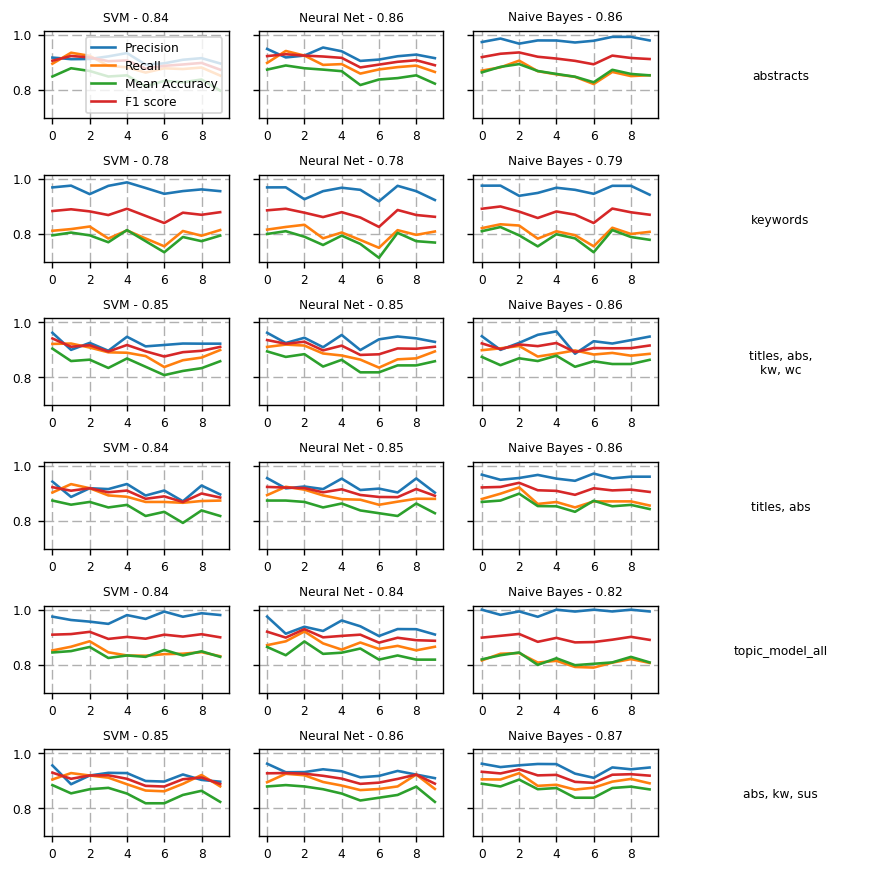

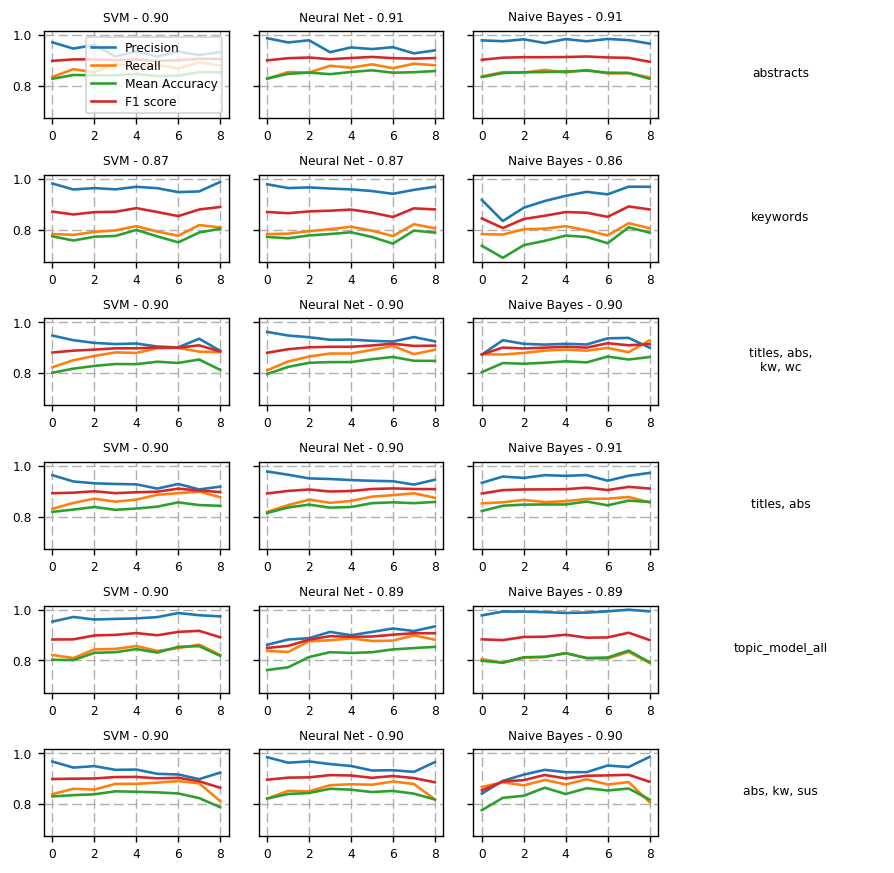

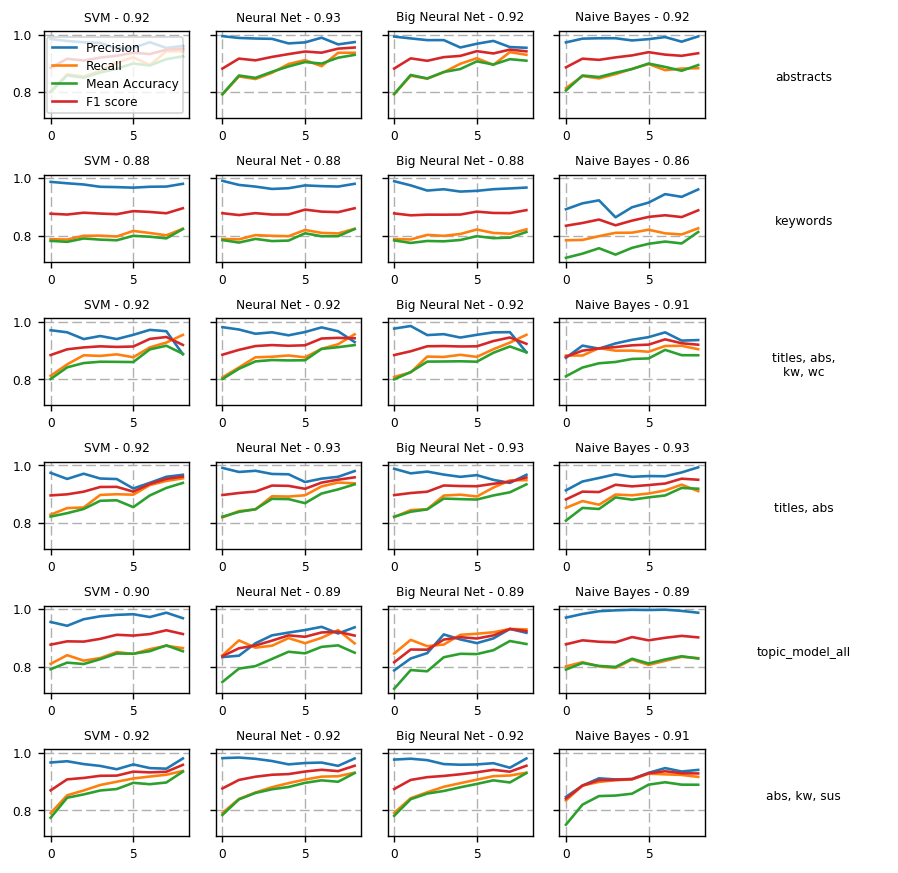

In [19]:
plt.rcParams['grid.linestyle'] = "--"
fig, axs = plt.subplots(
    len(xs),
    len(xs[0]['models'])+1,
    dpi=125,
    figsize=(double_figure[0],7),
    sharey=True
)
for i, x in enumerate(xs):
    for j, model in enumerate(x['models']):
        ax = axs[i,j]
        ax.plot(model['p'],label="Precision")
        ax.plot(model['r'],label="Recall")
        ax.plot(model['e'],label="Mean Accuracy")
        ax.plot(model['f'],label="F1 score")

        ax.set_title("{} - {:.2f}".format(model['title'],np.mean(model['f'])))
        ax.grid()
    ax = axs[i,len(xs[0]['models'])]
    ax.text(0.5,0.85,x['title'],ha="center",va="center")
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    ax.axis('off')
axs[0,0].legend()
fig.tight_layout()
plt.savefig("../plots/model_comparison_ssize.png")
plt.show()


## By adjusting our probability threshold we can prioritise precision or recall

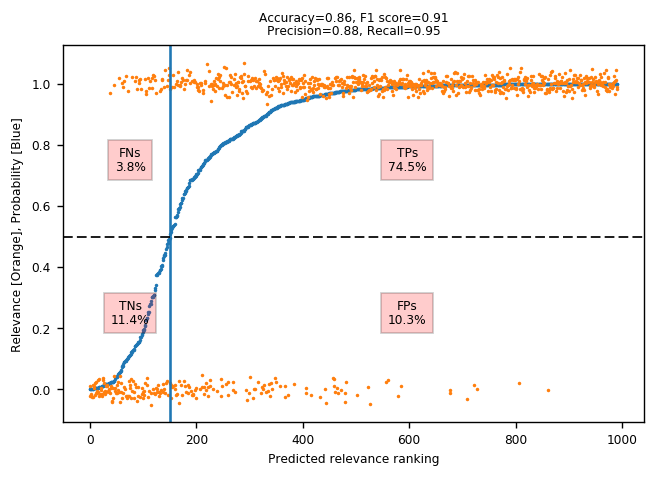

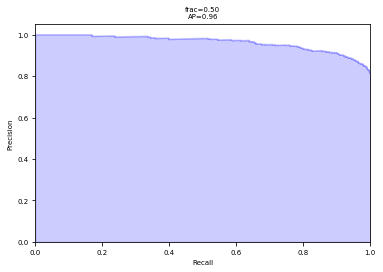

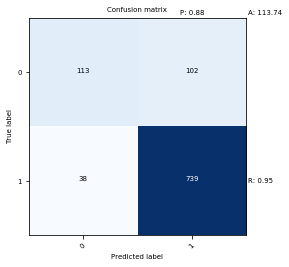

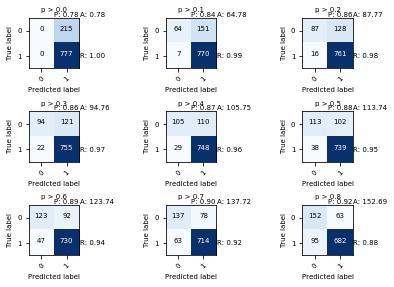

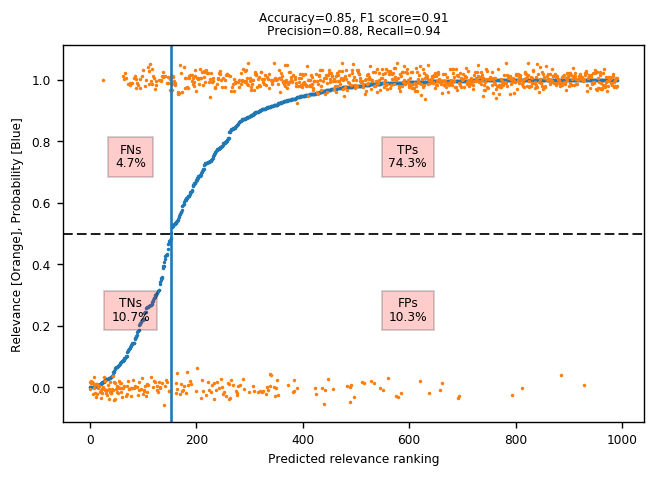

In [30]:
importlib.reload(utils)

local_x = ab_X

train = df.sample(frac=0.5).copy()
test = df[~df['id'].isin(train['id'])].copy()

clf = MLPClassifier(
            solver='lbfgs', 
            alpha=0.5,
            hidden_layer_sizes=(1200), 
            random_state=1
        )
#clf = MultinomialNB(alpha=0.1) 

clf.fit(local_x[train.index],y[train.index])

fig, ax = plt.subplots(dpi=125)

#print("Accuracy: {:.2f}".format(clf.score(local_x[test.index],y[test.index])))

utils.plot_model_accuracy(clf,local_x[test.index],y[test.index],ax, 0.5)

plt.show()

In [21]:
local_x.shape

(1984, 2088)

In [22]:
importlib.reload(utils)

fig, ax = plt.subplots()
utils.precision_recall_plot(clf,local_x[test.index],y[test.index],ax,0.5)

Average precision-recall score: 0.96


In [23]:
from sklearn.metrics import confusion_matrix
fig = plt.figure()
cnf = confusion_matrix(y[test.index],clf.predict(ab_X[test.index]))
utils.plot_confusion_matrix(cnf,classes=[0,1])

Confusion matrix, without normalization
[[113 102]
 [ 38 739]]


In [24]:
y_prob = clf.predict_proba(local_x[test.index])[:,1]
t = 0.1
y_pred = np.where(y_prob>t,1,0)
fig = plt.figure()
for i in range(9):
    t = i*0.1
    y_pred = np.where(y_prob>t,1,0)
    ax = fig.add_subplot(3,3,i+1)
    cnf = confusion_matrix(y[test.index],y_pred)
    utils.plot_confusion_matrix(cnf,classes=[0,1])
    ax.set_title("p > {:.1f}".format(t))

#plt.colorbar()
    
fig.tight_layout()

Confusion matrix, without normalization
[[  0 215]
 [  0 777]]
Confusion matrix, without normalization
[[ 64 151]
 [  7 770]]
Confusion matrix, without normalization
[[ 87 128]
 [ 16 761]]
Confusion matrix, without normalization
[[ 94 121]
 [ 22 755]]
Confusion matrix, without normalization
[[105 110]
 [ 29 748]]
Confusion matrix, without normalization
[[113 102]
 [ 38 739]]
Confusion matrix, without normalization
[[123  92]
 [ 47 730]]
Confusion matrix, without normalization
[[137  78]
 [ 63 714]]
Confusion matrix, without normalization
[[152  63]
 [ 95 682]]


## False positives and false negatives

In [25]:
test['predicted'] = clf.predict(ab_X[test.index])
test['prob'] = clf.predict_proba(ab_X[test.index])[:,1]
fps = test[test['predicted']-test['relevant']==1].sort_values('prob',ascending=False)

fps.head()

,Unnamed: 0,UT_id,authors,content,first_author,id,rated,relevant,tag,title,wosarticle__de,wosarticle__wc,date,predicted,prob
192,2720,WOS:000302362300017,"Javaheri, M, Naimi-Jamal, MR, Dekamin, MG, Kau...","In this study, trialkylsilyl ethers of indispe...","Javaheri, M",399666,2018-09-21 04:42:12.585741+00:00,0,753,GASEOUS NITROGEN DIOXIDE FOR SUSTAINABLE OXIDA...,Catalyzed elimination; gaseous nitrogen dioxid...,"['Chemistry, Inorganic & Nuclear; Chemistry, O...",2018-09-21 04:42:12,1,0.999465
1061,2301,WOS:000224172400004,"Biswas, RR",This paper studies the unusual growth of the i...,"Biswas, RR",684450,2018-09-21 08:55:58.101001+00:00,0,753,"Making a technopolis in Hyderabad, India: the ...",information technology; regional sustainabilit...,['Business; Planning & Development'],2018-09-21 08:55:58,1,0.998706
1577,162,WOS:000282347500011,"Yang, ZM, Yang, ZM, Guo, RB, Xu, XH, Fan, XL, ...",Energy recovery from lipid-extracted microalga...,"Yang, ZM",10717,2018-09-21 11:49:35.459165+00:00,0,760,Enhanced hydrogen production from lipid-extrac...,Hydrogen production; Lipid-extracted microalga...,"['Chemistry, Physical; Electrochemistry; Energ...",2018-09-21 11:49:35,1,0.997265
1842,2373,WOS:000229341300001,"Claereboudt, MR, McIlwain, JL, Al-Oufi, HS, Am...",Patterns of reproduction and spawning were det...,"Claereboudt, MR",231000,2018-09-21 12:43:46.644355+00:00,0,760,Patterns of reproduction and spawning of the k...,Scomberomorus commerson; Sultanate of Oman; re...,['Fisheries'],2018-09-21 12:43:46,1,0.997092
184,788,WOS:000257628400009,"Macher, C, Guyader, O, Talidec, C, Bertignac, M",The Nephrops trawl fishery is one of the most ...,"Macher, C",686419,2018-09-24 04:24:08.321493+00:00,0,753,A cost-benefit analysis of improving trawl sel...,Nephrops norvegicus; bio-economic simulations;...,['Fisheries'],2018-09-24 04:24:08,1,0.996639


In [26]:
print('#########\nFALSE POSITIVES')

for i, row in fps.head(5).iterrows():
    print('\n####')
    print(row['title'])
    print("predicted: {:.2}, rated: {}".format(row['prob'],row['relevant']))
    print(row['content'])

#########
FALSE POSITIVES

####
GASEOUS NITROGEN DIOXIDE FOR SUSTAINABLE OXIDATIVE DEPROTECTION OF TRIMETHYLSILYL ETHERS
predicted: 1.0, rated: 0
In this study, trialkylsilyl ethers of indispensable protected alcohols are oxidatively deprotected in neat form with gaseous nitrogen dioxide (NO2). Quantitative yields of aldehydes or ketones are obtained without the necessity of chromatography. The byproducts, nitrogen monoxide, anhydrous nitric acid, and hexamethyldisiloxane, can be quantitatively separated by evaporation and distillation in closed systems for recycling or further use. The direct new method supersedes the previous techniques that produce dangerous wastes and require chromatographic workup, while the atmospheric gas NO2 and its gaseous reduction products are easily kept in closed systems until further use.

####
Making a technopolis in Hyderabad, India: the role of government IT policy
predicted: 1.0, rated: 0
This paper studies the unusual growth of the information techno

In [27]:
fns = test[test['predicted']-test['relevant']==-1].sort_values('prob')

fns.head()

,Unnamed: 0,UT_id,authors,content,first_author,id,rated,relevant,tag,title,wosarticle__de,wosarticle__wc,date,predicted,prob
1351,1930,WOS:000340768600006,"Hemphill, L, Berry, J, McGreal, S",Urban regeneration has increasingly emphasised...,"Hemphill, L",183173,2018-09-20 07:55:51.885088+00:00,1,753,A financial appraisal of business improvement ...,business improvement districts; urban regenera...,['Environmental Studies; Public Administration'],2018-09-20 07:55:51,0,0.021396
930,740,WOS:000363069800008,"Villegas, L, Moran, R, Garcia, JJ",Guadua angustifolia (GA) is an American specie...,"Villegas, L",410826,2018-09-24 03:58:44.906857+00:00,1,760,A new joint to assemble light structures of ba...,Guadua angustifolia; Ductile behavior; Structu...,['Construction & Building Technology; Engineer...,2018-09-24 03:58:44,0,0.027413
595,564,WOS:000374156600002,"Agarwal, R, Green, R, Agarwal, N, Randhawa, K",Purpose - The purpose of this paper is to inve...,"Agarwal, R",413540,2018-09-21 04:49:45.436555+00:00,1,753,Benchmarking management practices in Australia...,Performance management; Management; Human reso...,['Health Policy & Services'],2018-09-21 04:49:45,0,0.054049
1391,2841,WOS:000359048200001,"Weinhardt, LS, Galvao, LW, Mwenyekonde, T, Gra...","Background: Poverty and lack of a predictable,...","Weinhardt, LS",173287,2018-09-19 15:53:32.739740+00:00,1,753,Methods and protocol of a mixed method quasi-e...,Food security; Microfinance; Village savings a...,['Multidisciplinary Sciences'],2018-09-19 15:53:32,0,0.072031
458,1598,WOS:000313416900007,"Ruiz, MJ, van Dijk, MG, Berdichevsky, K, Mungu...",Maternal mortality among indigenous women in G...,"Ruiz, MJ",11060,2018-09-19 04:58:16.484705+00:00,1,753,Barriers to the use of maternity waiting homes...,maternal care; maternity waiting homes; indige...,"['Family Studies; Social Sciences, Biomedical']",2018-09-19 04:58:16,0,0.084507


In [28]:
print('#########\nFALSE NEGATIVES')

for i, row in fns.head(5).iterrows():
    print('\n####')
    print(row['title'])
    print("predicted: {:.2}, rated: {}".format(row['prob'],row['relevant']))
    print(row['content'])

#########
FALSE NEGATIVES

####
A financial appraisal of business improvement districts in the UK
predicted: 0.021, rated: 1
Urban regeneration has increasingly emphasised long-term policy objectives and public-private partnership arrangements where risk and profits are more equitably distributed between the parties. Similarly, successive governments have endorsed area-based regeneration vehicles with increasing importance placed on enterprise zones, business improvement districts (BIDs), tax incremental finance, and other local asset backed vehicles. Each regeneration vehicle necessitates a clear policy direction and performance measurement of its policy outputs to ensure that funding is targeted at initiatives delivering sustainability impacts. This paper presents a 'market' and ` nonmarket' appraisal of the financial impact of BIDs as an area-based regeneration vehicle. It utilises data from a UK-wide survey to demonstrate the potential of BIDs in generating direct income and indire

## Todos:
- Sustainable x features
- Ensemble methods, autosklearn
- Error overlap
- category exclusion

In [29]:



sus_tokenize( "The concept of long-term sustainable development")

# keywords



NameError: name 'sus_tokenize' is not defined

In [ ]:
importlib.reload(utils)

local_x = sus_X
local_x = hstack([ab_X,sus_X],format="csr")


train = df.sample(frac=0.5).copy()
test = df[~df['id'].isin(train['id'])].copy()

train_index = utils.undersample(train.index,y,0.6)

clf = MLPClassifier(
            solver='lbfgs', 
            alpha=0.2,
            hidden_layer_sizes=(100,20,5), 
            random_state=1
        )
#clf = MultinomialNB(alpha=0.1) 

clf.fit(local_x[train_index],y[train_index])


print("Accuracy: {:.2f}".format(clf.score(local_x[test.index],y[test.index])))



In [ ]:
fig, ax = plt.subplots(dpi=125)

utils.plot_model_accuracy(clf,local_x[test.index],y[test.index],ax, 0.95)

In [ ]:
model = clf
y_test = y[test.index]
x_test = local_x[test.index]
y_prob = model.predict_proba(x_test)
prob_y_true = y_prob[:,1]
prob_y_false = y_prob[:,0]

order = np.argsort(prob_y_true)
ordered_prob = prob_y_true[order]

order

np.array(y_test)[order]

In [ ]:
fig, ax = plt.subplots(dpi=125)
utils.precision_recall_plot(clf,local_x[test.index],y[test.index],ax,0.5)

In [ ]:
cnf = confusion_matrix(y[test.index],clf.predict(local_x[test.index]))
utils.plot_confusion_matrix(cnf,classes=[0,1])